## 1. Setup and Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import wandb
from tqdm import tqdm


## 2. Data Preparation and wandb login

In [2]:
train_dir = "/kaggle/working/inaturalist_12K/train"  # Update as needed
test_dir = "/kaggle/working/inaturalist_12K/train"


In [3]:
wandb.login(key='613aac3388325cb6206db61e3c1a38a707589743')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip

# import os
# os.listdir('/kaggle/working/')

--2025-04-17 17:22:14--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 74.125.201.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   218MB/s    in 16s     

2025-04-17 17:22:30 (234 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

Archive:  nature_12K.zip
   creating: inaturalist_12K/
  inflating: inaturalist_12K/.DS_Store  
   creating: inaturalist_12K/train/
   creating: inaturalist_12K/train/Plantae/
  inflating: inaturalist_12K/train/Plantae/1dfc3916ad58af6ce9af9fc8b36ceedd.jpg  
  inflating: inaturalist_12K/train/Plantae/e49eeff2b27ae74351fdf8ffa3791307.jpg  
  inflating: inaturalist_12K/train/Plantae/519ae1c558dff337bb4084934e31a4a8.jpg  

### ImageNet normalization (required for ResNet50):

In [5]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms(augment=False):
    if augment:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std)
        ])


### Stratified train/val split:

In [6]:
def stratified_split(dataset, val_pct=0.2):
    targets = np.array([y for _, y in dataset.samples])
    train_idx, val_idx = [], []
    for c in np.unique(targets):
        idx = np.where(targets == c)[0]
        np.random.shuffle(idx)
        split = int(len(idx) * (1 - val_pct))
        train_idx.extend(idx[:split])
        val_idx.extend(idx[split:])
    return torch.utils.data.Subset(dataset, train_idx), torch.utils.data.Subset(dataset, val_idx)


## 3. Model Loader and Freezing Strategy

In [7]:
def get_resnet50(num_classes):
    model = models.resnet50(weights="IMAGENET1K_V1")
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def freeze_layers(model, strategy="fc_only"):
    for param in model.parameters():
        param.requires_grad = False
    if strategy == "fc_only":
        for param in model.fc.parameters():
            param.requires_grad = True
    elif strategy == "last_block":
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True
    elif strategy == "all_unfrozen":
        for param in model.parameters():
            param.requires_grad = True


## 4. Sweep Configuration (WandB)

In [13]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "lr": {"values": [1e-3, 5e-4, 1e-4]},
        "batch_size": {"values": [32, 64]},
        "epochs": {"value": 6},
        "augment": {"values": [True, False]},
        "freeze_strategy": {"values": ["fc_only", "last_block", "all_unfrozen"]}
    }
}


## 5. Training and Evaluation Functions

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


## 6. Sweep Training Function

In [15]:
def sweep_train():
    wandb.init()
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data transforms and loaders
    train_full = datasets.ImageFolder(train_dir, transform=get_transforms(config.augment))
    train_subset, val_subset = stratified_split(train_full, val_pct=0.2)
    train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    # Model and freezing
    model = get_resnet50(num_classes=10)
    freeze_layers(model, config.freeze_strategy)
    model = model.to(device)

    # Optimizer and loss
    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(params, lr=config.lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    for epoch in range(config.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            wandb.save("best_model.pth")


## 7. Run the Sweep (10 Runs)

In [16]:
sweep_id = wandb.sweep(sweep_config, project="inat-finetune-sweep-resnet50")
wandb.agent(sweep_id, function=sweep_train, count=10)

Create sweep with ID: 69fbldz1
Sweep URL: https://wandb.ai/da24s006-indian-institue-of-technology-madras-/inat-finetune-sweep-resnet50/sweeps/69fbldz1


wandb: Agent Starting Run: 5spumfl2 with config:
wandb: 	augment: False
wandb: 	batch_size: 32
wandb: 	epochs: 6
wandb: 	freeze_strategy: fc_only
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 3o6fxyzc with config:
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	epochs: 6
wandb: 	freeze_strategy: fc_only
wandb: 	lr: 0.0001


wandb: Agent Starting Run: jk7mjdlu with config:
wandb: 	augment: False
wandb: 	batch_size: 32
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: sx3lwsr8 with config:
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: x7t6avj9 with config:
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 5f1lcnya with config:
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	epochs: 6
wandb: 	freeze_strategy: all_unfrozen
wandb: 	lr: 0.0005


wandb: Agent Starting Run: jwl8b3w7 with config:
wandb: 	augment: False
wandb: 	batch_size: 32
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: 3y608dlw with config:
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: opbrd0ju with config:
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	epochs: 6
wandb: 	freeze_strategy: last_block
wandb: 	lr: 0.0005


wandb: Agent Starting Run: ebellsyd with config:
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	epochs: 6
wandb: 	freeze_strategy: fc_only
wandb: 	lr: 0.0001


## 8. Evaluate Best Model on Test Set

In [20]:

best_config = {
    "freeze_strategy": "fc_only"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = datasets.ImageFolder(test_dir, transform=get_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

model = get_resnet50(num_classes=10)
freeze_layers(model, best_config["freeze_strategy"])
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
print(f"Test Accuracy: {test_acc:.4f}")


/tmp/ipykernel_31/2388349104.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


Test Accuracy: 0.7444


**Test Accuracy: 74.44%**     
to check and confirm it, please load the model best_model.pth and evalute on the test data.

### To visualize predictions:

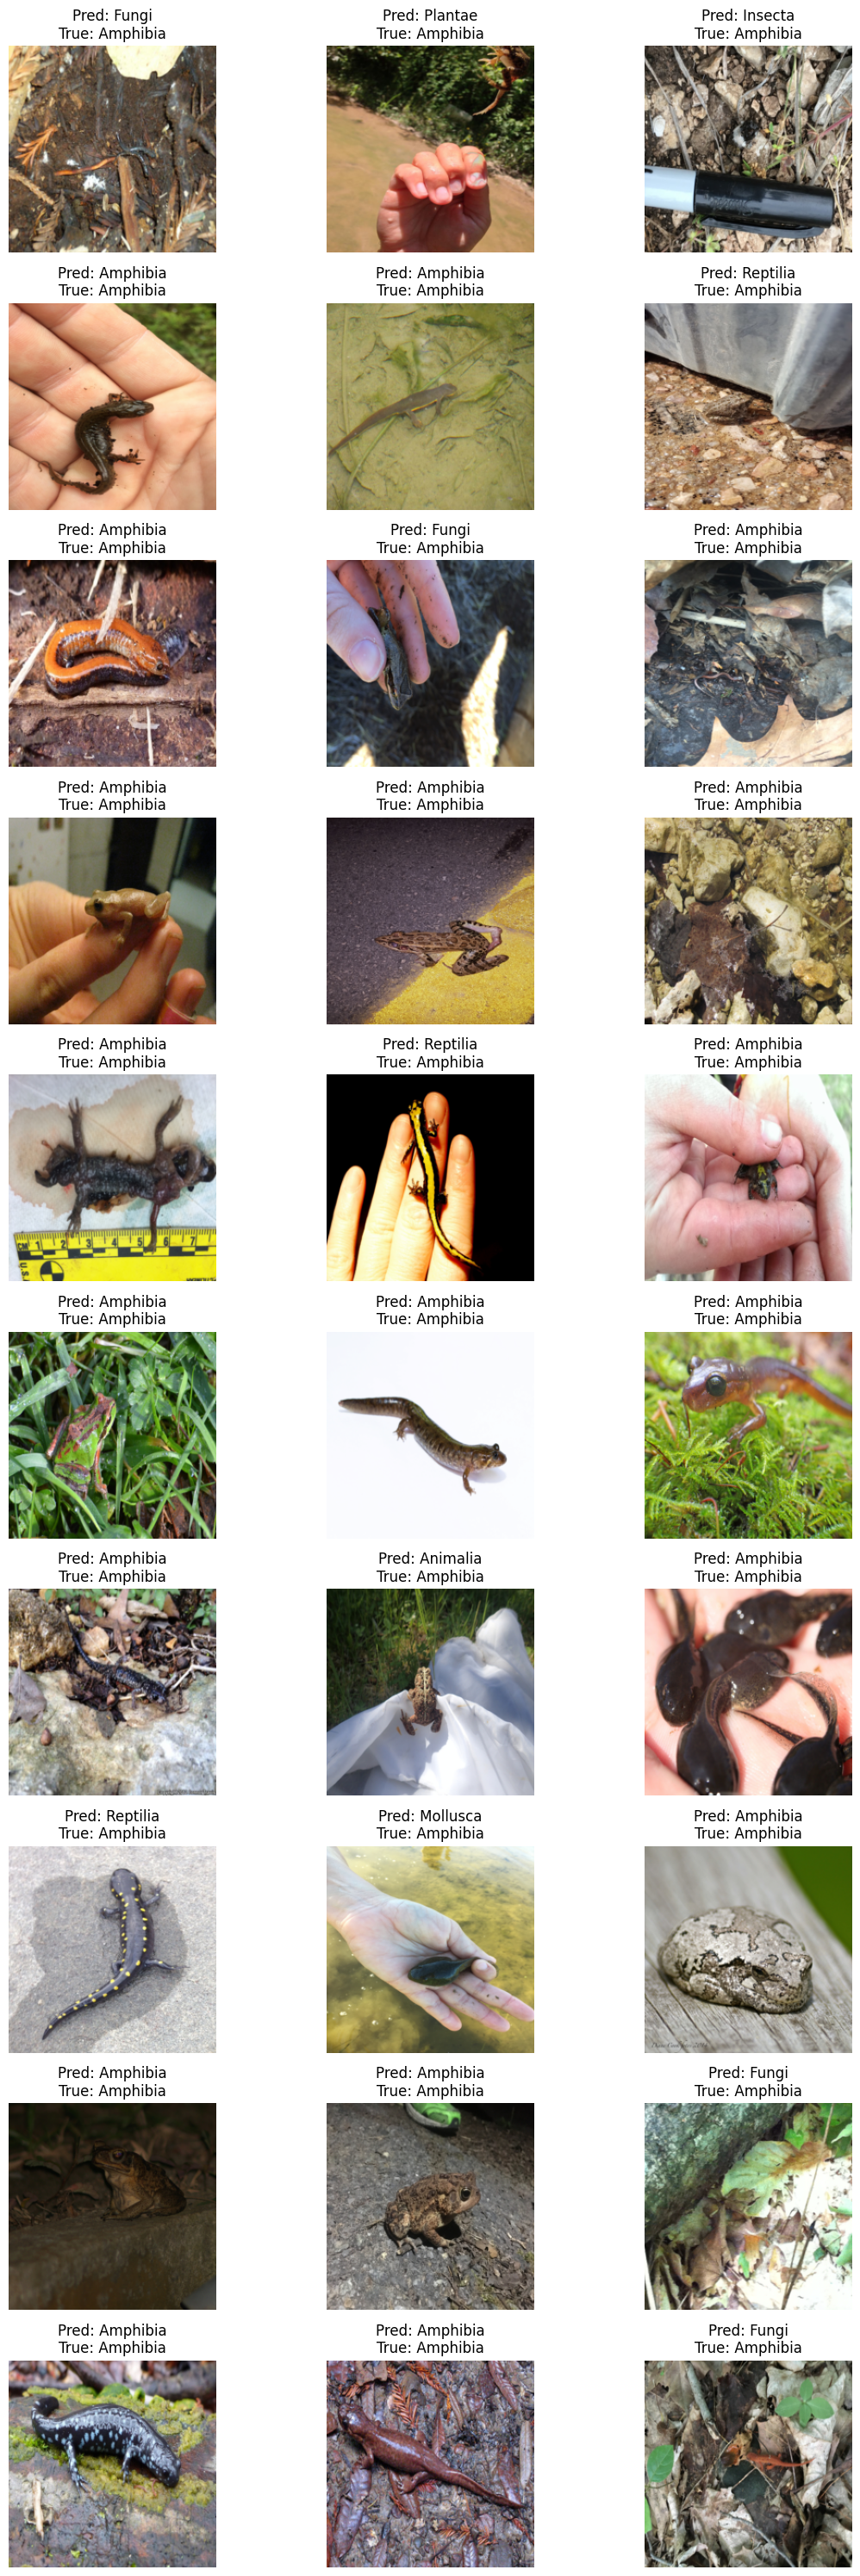

In [18]:
import matplotlib.pyplot as plt

classes = test_dataset.classes
images_shown, preds_shown, labels_shown = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = outputs.argmax(dim=1).cpu()
        images_shown.extend(images)
        preds_shown.extend(preds)
        labels_shown.extend(labels)
        if len(images_shown) >= 30:
            break

fig, axes = plt.subplots(10, 3, figsize=(12, 30))
for i, ax in enumerate(axes.flat):
    img = images_shown[i].permute(1,2,0).numpy() * np.array(imagenet_std) + np.array(imagenet_mean)
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[preds_shown[i]]}\nTrue: {classes[labels_shown[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()
